# Homework 08: Detecting Distribution Shift on MNIST using Bayesian Neural Networks

## <span style="color:Orange">Overview</span>

In this exercise we will compare Bayesian NNs with deterministic NNs on a distribution shift detection task. To do this, we'll monitor the predictive entropy as the distribution gradually shifts.  A model with better uncertainty quantification should become less certain---that is, have a more entropic predictive distribution---as the input distribution shifts.  Mathematically, our quantity of interest is:

$$ \Large
\mathbb{H}[y | x^{*}, D] = - \sum_{y} p(y | x^{*}, D) \log p(y | x^{*}, D)
$$ 

where $p(y | x^{*}, D)$ is the predictive distribution: 

$$ \Large
p(y | x^{*}, D) = \int_{\theta} p(y | x^{*}, \theta) \ p(\theta | D) \ d \theta.
$$

The goal is to obtain something similar to Figure #4 from the paper [Multiplicative Normalizing Flows for Variational Bayesian Neural Networks](https://arxiv.org/abs/1603.04733), comparing MC dropout, ensembles, and a Bayesian NN. 

We will be using the well-known MNIST dataset, a set of 70,000 hand-written digit images, and we will generate a gradual distribution shift on the dataset by rotating the images. As such, the final plot will depict the change in the entropy of the predictive distribution (y-axis) as degree of rotation increases (x-axis). The paper above shows the result for one image.  We, on the other hand, will average over multiple images to make a better comparison between models.

We'll use rotation to simulate a smooth shift. Here's how you can rotate a given image: 

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

torch.manual_seed(42)
np.random.seed(42)

from PIL import Image
from torchvision import datasets
from torch.nn.functional import softmax
from torchvision.transforms.functional import rotate

c:\Users\ajwef\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def imshow(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [4]:
def show_rotation_on_mnist_example_image():
    mnist_train = datasets.MNIST('./tmp_data', train=True, download=False)
    image = Image.fromarray(mnist_train.data[0].numpy())
    imshow(image)
    rotated_image = rotate(image, angle=90)
    imshow(rotated_image)

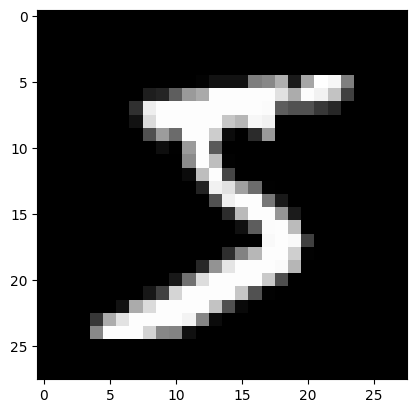

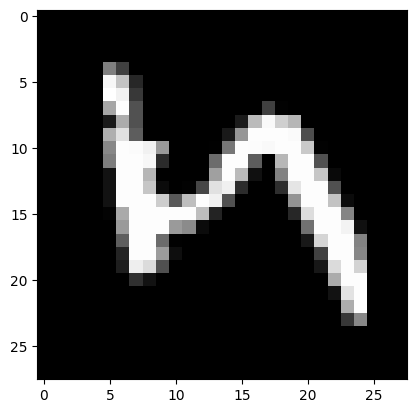

In [5]:
show_rotation_on_mnist_example_image()

Let's setup the training and testing data:

In [6]:
def get_mnist_data(train=True):
    mnist_data = datasets.MNIST('../data', train=train, download=False)
    x = mnist_data.data.reshape(-1, 28 * 28).float()
    y = mnist_data.targets
    return x, y

x_train, y_train = get_mnist_data(train=True)
x_test, y_test = get_mnist_data(train=False)

Now that we have the data, let's start training neural networks.

## <span style="color:Orange">Define non-Bayesian (Deterministic) Neural Network</span>

We will reuse our MLP network architecture with different hyperparameters:

First let's create our point estimate neural network, in other words a standard fully connected MLP. We will define the number of hidden layers dynamically so we can reuse the same class for different depths.  We will also add a ___<span style="color:violet">dropout</span>___ flag, this will allow us to easily use the same architecture for our BNN. 

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.Tanh()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)

            hidden = hidden_temp + hidden  # residual connection

        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean

## <span style="color:Orange">Problem 1: Deterministic Neural Network</span>

In [8]:
net = MLP(input_dim=784, output_dim=10, hidden_dim=30, n_hidden_layers=3)

### <span style="color:LightGreen">Training</span>

In [9]:
def train_on_mnist(net):
    x_train, y_train = get_mnist_data(train=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    batch_size = 250

    progress_bar = trange(20)
    for _ in progress_bar:
        for batch_idx in range(int(x_train.shape[0] / batch_size)):
            batch_low, batch_high = batch_idx * batch_size, (batch_idx + 1) * batch_size
            optimizer.zero_grad()
            loss = criterion(target=y_train[batch_low:batch_high], input=net(x_train[batch_low:batch_high]))
            progress_bar.set_postfix(loss=f'{loss / batch_size:.3f}')
            loss.backward()
            optimizer.step()
    return net

In [10]:
net = train_on_mnist(net)

  0%|          | 0/20 [00:00<?, ?it/s, loss=0.008]

100%|██████████| 20/20 [00:16<00:00,  1.21it/s, loss=0.001]


### <span style="color:LightGreen">Testing</span>

In [11]:
def accuracy(targets, predictions):
  return (targets == predictions).sum() / targets.shape[0]

In [57]:
def evaluate_accuracy_on_mnist(net):
    test_data = get_mnist_data(train=False)
    x_test, y_test = test_data
    net.eval()
    y_preds = net(x_test).argmax(1)
    acc = accuracy(y_test, y_preds)
    print("Test accuracy is %.2f%%" % (acc.item() * 100))

In [56]:
evaluate_accuracy_on_mnist(net)

tensor([7, 2, 1,  ..., 4, 5, 6])
Test accuracy is 92.58%


### <span style="color:LightGreen">Rotating the Images</span>

Now let's compute predictive entropy on some rotated images...

First we will generate the rotated images with an increasing rotation angle from the test images. We use a subset of the MNIST test set for evaluation:

In [14]:
def get_mnist_test_subset(n_test_images):
    mnist_test = datasets.MNIST('../data', train=False, download=True)
    x = mnist_test.data[:n_test_images].float()
    y = mnist_test.targets[:n_test_images]
    return x, y

In [15]:
n_test_images = 100
x_test_subset, y_test_subset = get_mnist_test_subset(n_test_images=n_test_images)

In [16]:
rotation_angles = [3 * i for i in range(0, 31)] # use angles from 0 to 90 degrees
rotated_images = [rotate(x_test_subset, angle).reshape(-1, 28 * 28) for angle in rotation_angles]

### <span style="color:LightGreen">Evaluating on the Rotated Images</span>

In [17]:
y_preds_deterministic = [softmax(net(images), dim=-1) for images in rotated_images]


The [information entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) $H$ of a probability distribution $p$ over a discrete random variable $X$ with possible outcomes $x_1, \ldots, x_N$, occuring with probabilities $p(x_i) := p_i$ is given by: 

$$ \Large
H(p) = - \sum_{i=1}^{N} p_i \log p_i
$$

The entropy quantifies the uncertainty of a probability distribution in the sense, that the more uncertain the outcome a hypothetical experiment with drawing from the distribution is the higher the entropy. Highest is for an equal distribution of probability mass over all possible outcomes.
In our case the deterministic NN estimates a probability distribution over the ten digits as classes on MNIST for each image. For the rotated images we can thus calculate the entropy over the rotation angle. 

<span style="color:Yellow">Question:</span> How do you expect the entropy to behave with increasing rotation angle of the images? Answer in the cell below:

I would expect the entropy to increase as the images get rotated. As they get rotated, the symbols will look less like any of the 10 digits and the probabilities will become more uniform.

Implement a function for calculating the entropy according to the formula above

In [18]:
def entropy(p):

  # YOUR CODE HERE
  return -np.sum(p * np.log(p), axis=1)

Now we can calculate the accuracies and entropies for all rotated images and plot both:

In [19]:
def calculate_accuracies_and_entropies(y_preds):
    accuracies = [accuracy(y_test_subset, p.argmax(axis=1)) for p in y_preds]
    entropies = [np.mean(entropy(p.detach().numpy())) for p in y_preds]
    return accuracies, entropies

In [20]:
def plot_accuracy_and_entropy(add_to_plot):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlim([0, 90])
    plt.xlabel("Rotation Angle", fontsize=20)

    add_to_plot(ax)

    plt.legend()
    plt.show()

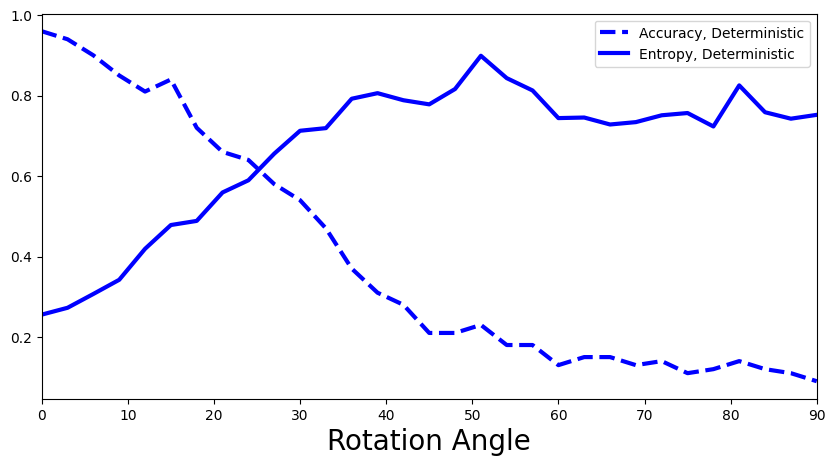

In [21]:
def add_deterministic(ax):
    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_deterministic)
    ax.plot(rotation_angles, accuracies, 'b--', linewidth=3, label="Accuracy, Deterministic")
    ax.plot(rotation_angles, entropies, 'b-', linewidth=3, label="Entropy, Deterministic")
plot_accuracy_and_entropy(add_deterministic)

<span style="color:Yellow">Question:</span> What is your interpretation of the plot above: Is the predictive entropy changing? If so, how would you explain this? Answer in the cell below:

The predictive entropy increased with the rotation angle, as the numbers rotate, they become less recognizable and thus have more equal probabilities across the different numbers.

## <span style="color:Orange">Problem 2: Monte Carlo Dropout Network</span>

Let's create our Dropout Network. We keep the network depth and hidden layer size the same as for the MLP for a fair model comparison

In [22]:
net_dropout = MLP(input_dim=784, output_dim=10, hidden_dim=30, n_hidden_layers=3, use_dropout=True)

### <span style="color:LightGreen">Training</span>

In [23]:
net_dropout = train_on_mnist(net_dropout)

  0%|          | 0/20 [00:00<?, ?it/s, loss=0.008]

100%|██████████| 20/20 [00:14<00:00,  1.40it/s, loss=0.001]


### <span style="color:LightGreen">Testing</span>

In [24]:
evaluate_accuracy_on_mnist(net_dropout)

Test accuracy is 92.45%


### <span style="color:LightGreen">Evaluating on the Rotated Images</span>

Sample 100 different dropout masks and average the predictions over them (store the predictions in a list called `y_pred_dropout`)

In [63]:
n_dropout_samples = 100
net_dropout.train()  # we set the model to train to 'activate' the dropout layer

# YOUR CODE HERE
y_preds_dropout = []
for images in rotated_images:
    samples = [net_dropout(images) for _ in range(n_dropout_samples)]
    samples = torch.stack(samples)
    avg = torch.mean(samples, axis=0)
    y_preds_dropout.append(softmax(avg, dim=-1))
    
#     temp = [net_dropout(images).clone().detach().numpy() for _ in range(n_dropout_samples)]
#     temp = np.array(temp)
#     out.append(np.mean(temp))
# out = torch.tensor(out)
# print(out)
# drops = [net_dropout(i) for i in range(n_dropout_samples)]
# y_preds_dropout = [softmax(torch.tensor(torch.mean(torch.stack([net_dropout(images)for _ in range(n_dropout_samples)]), axis=0)), dim=-1) for images in rotated_images]
# print(y_preds_dropout)
# print(y_preds_deterministic)
# print(y_preds_dropout)
# print(len(y_preds_deterministic))


<span style="color:Yellow">Question:</span> What is the best way to average over the predictions? Should you first average the network output and then apply the softmax, or the other way around? Answer in the cell below:

The best way to average is to do the average of the network first, then apply the softmax. This ensures your probabilities always add up to 1, whereas in the other order, floating point errors can cause your probabilities to not be normalized. 

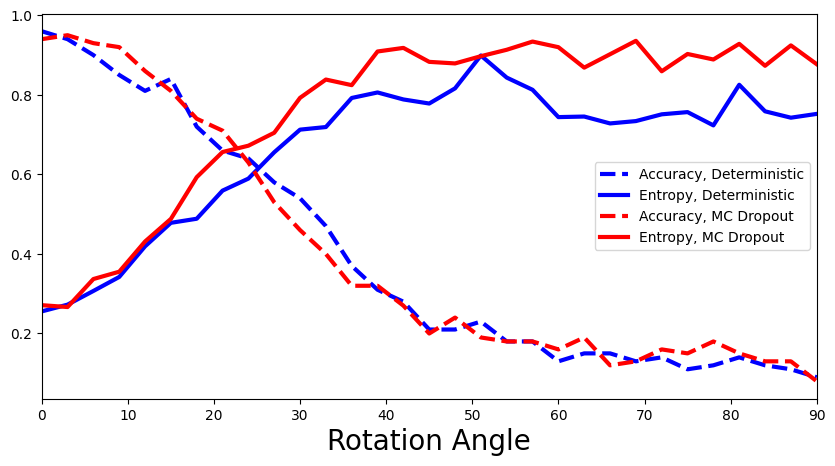

In [64]:
def add_deterministic_and_dropout(ax):
    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_deterministic)
    ax.plot(rotation_angles, accuracies, 'b--', linewidth=3, label="Accuracy, Deterministic")
    ax.plot(rotation_angles, entropies, 'b-', linewidth=3, label="Entropy, Deterministic")
    
    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_dropout)
    ax.plot(rotation_angles, accuracies, 'r--', linewidth=3, label="Accuracy, MC Dropout")
    ax.plot(rotation_angles, entropies, 'r-', linewidth=3, label="Entropy, MC Dropout")
plot_accuracy_and_entropy(add_deterministic_and_dropout)

<span style="color:Yellow">Question:</span> How does MLP compare with MC-Dropout Network? (Are there any benefits of the Bayesian approach?). Answer in the cell below:

They seem to be about the same, although the dropout is actually worse in terms of entropy than the deterministic model. In this case, the Bayesian approach didn't seem to buy us much. Its possible that with different combinations of hyperparameters, the dropout network would preform better.

## <span style="color:Orange">Problem 3: Deep Ensemble</span>

Deep ensembles were first introduced by [Lakshminarayanan et al. (2017)](https://arxiv.org/abs/1612.01474). As the name implies multiple point estimate NN are trained, ___<span style="color:violet">an ensemble</span>___, and the final prediction is computed as an average across the models. From a Bayesian perspective the different point estimates correspond to modes of a Bayesian posterior. This can be interpreted as approximating the posterior with a distribution parametrized as multiple Dirac deltas:

$$ \Large
q_{\phi}(\theta | D) = \sum_{\theta_{i} ∈ ϕ} \alpha_{\theta_{i}} δ_{\theta_{i}}(\theta)
$$

where $\alpha_{\theta_{i}}$ are positive constants such that their sum is equal to one.

Now let's investigate Deep Ensemble performance. We will use the exact same network hyperparameters as for the MLP:

Define and train an ensemble of five MLPs with the same hyperparameters as above. First generate the ensembles (store in a list called `ensemble`)

In [27]:
ensemble_size = 5

# YOUR CODE HERE

ensemble = []
for i in range(ensemble_size):
    net = MLP(input_dim=784, output_dim=10, hidden_dim=30, n_hidden_layers=3)
    ensemble.append(net)

### <span style="color:LightGreen">Training</span>

In [28]:
for net in ensemble:
  train_on_mnist(net)

  0%|          | 0/20 [00:00<?, ?it/s, loss=0.009]

100%|██████████| 20/20 [00:14<00:00,  1.39it/s, loss=0.001]


### <span style="color:LightGreen">Testing</span>

Evaluate the accuracy of the ensemble prediction. ___Hints___: How do you aggregate best over the multiple different predictions given by the members of the ensemble? What is the difference to the regression setting above?v

In [58]:
# YOUR CODE HERE
def evaluate_ensemble_accuracy_on_mnist(nets):
    test_data = get_mnist_data(train=False)
    x_test, y_test = test_data
    store_y_preds = []
    for net in nets:
        net.eval()
        temp_y_preds = net(x_test).argmax(1)
        store_y_preds.append(temp_y_preds)
        # print(temp_y_preds)
    print(len(store_y_preds[0]))
    store_y_preds = np.array(store_y_preds).T
    y_preds = []
    for arr in store_y_preds:
        vals, counts = np.unique(arr, return_counts=True)
        mode_idx = np.random.choice(np.argwhere(counts == np.max(counts)).flatten())
        # print(mode_idx)
        y_preds.append(arr[mode_idx].flatten().tolist())
    print(y_preds)
    y_preds = torch.tensor(np.reshape(np.array(y_preds), -1))
    print(y_preds)
    acc = accuracy(y_test, y_preds)
    print("Test accuracy is %.2f%%" % (acc.item() * 100))
    
evaluate_ensemble_accuracy_on_mnist(ensemble)
# y_preds = NotImplemented

10000
[[7], [2], [1], [0], [4], [1], [4], [9], [6], [9], [0], [6], [9], [0], [1], [5], [9], [7], [2], [4], [9], [6], [6], [5], [4], [0], [7], [4], [0], [1], [3], [1], [3], [0], [7], [2], [7], [1], [3], [1], [1], [7], [4], [2], [3], [5], [1], [2], [4], [4], [6], [3], [5], [5], [6], [0], [4], [1], [9], [5], [7], [8], [9], [3], [7], [4], [6], [4], [3], [0], [7], [0], [2], [9], [1], [7], [3], [2], [9], [7], [7], [6], [2], [7], [8], [4], [7], [3], [6], [1], [3], [6], [9], [3], [1], [4], [1], [7], [6], [9], [6], [0], [5], [4], [9], [9], [2], [1], [9], [4], [8], [7], [3], [9], [7], [4], [4], [4], [9], [2], [5], [4], [7], [6], [4], [9], [0], [5], [8], [5], [6], [6], [5], [7], [8], [1], [0], [1], [6], [4], [6], [7], [2], [1], [7], [1], [8], [2], [0], [9], [9], [2], [5], [5], [1], [5], [6], [0], [3], [4], [4], [6], [5], [4], [6], [5], [4], [5], [1], [4], [4], [7], [2], [3], [2], [7], [1], [8], [1], [8], [1], [8], [5], [0], [8], [9], [2], [3], [0], [1], [1], [1], [0], [9], [0], [8], [1], [6], [4]

### <span style="color:LightGreen">Evaluating on the Rotated Images</span>

Again, average the predictions, but this time over the members of the ensemble (store the predictions in a list called `y_preds_ensemble`)

In [74]:

# YOUR CODE HERE
y_preds_ensemble = []
for images in rotated_images:
    samples = [ensemble[i](images) for i in range(5)]
    # print(samples)
    samples = torch.stack(samples)
    avg = torch.mean(samples, axis=0)
    # print(avg)
    y_preds_ensemble.append(softmax(avg, dim=-1))


In [75]:
def add_deep_ensemble(ax):
    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_deterministic)
    ax.plot(rotation_angles, accuracies, 'b--', linewidth=3, label="Accuracy, Deterministic")
    ax.plot(rotation_angles, entropies, 'b-', linewidth=3, label="Entropy, Deterministic")

    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_dropout)
    ax.plot(rotation_angles, accuracies, 'r--', linewidth=3, label="Accuracy, MC Dropout")
    ax.plot(rotation_angles, entropies, 'r-', linewidth=3, label="Entropy, MC Dropout")

    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_ensemble)
    ax.plot(rotation_angles, accuracies, 'g--', linewidth=3, label="Accuracy, Deep Ensemble")
    ax.plot(rotation_angles, entropies, 'g-', linewidth=3, label="Entropy, Deep Ensemble")

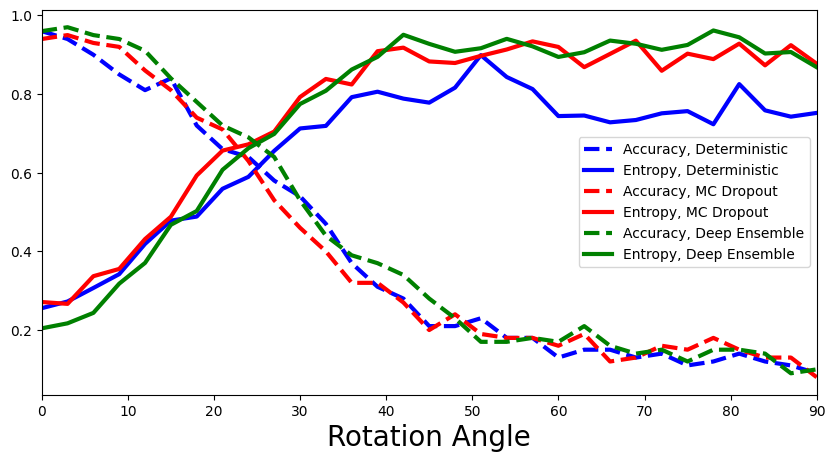

In [76]:
plot_accuracy_and_entropy(add_deep_ensemble)

<span style="color:Yellow">Question:</span> Are there any differences in the performance? Explain why you see or don't see any differences. Answer in the cell below:

The ensemble looks like it might be slightly betteter for low rotations. The ensemble is just 5 of the first network, so there shouldn't be much difference between them, only whatever random seeds went into their training. It would be interesting to train each of the ensemble more on specific areas, like each one specializes on 2 digits.

## [EXTRA CREDIT] <span style="color:Orange">Problem 4: Bayesian Neural Network</span>

First install pyro package:

In [ ]:
%pip install pyro-ppl

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.distributions import Normal, Categorical
from torch.nn.functional import softmax
from tqdm.auto import trange, tqdm

Implement a Bayesian Neural Network for classifying MNIST digits. For background on deep Bayesian networks, see the lecture notebook on [Uncertainty Quantification](AIExplainabilityUncertaintyQuantification.ipynb).

As a backbone use the MLP architecture introduced in the beginning of the notebook. However, because we will implement a custom *guide()*, define every layer explicitly.

In [ ]:
class My_MLP(nn.Module):
  '''
  Implement a MLP with 3 hidden layers, Tanh activation, no dropout or residual connections
  '''
  def __init__(self, in_dim=784, out_dim=10, hid_dim=200):
    super().__init__()
    assert in_dim > 0
    assert out_dim > 0
    assert hid_dim > 0

    # Define the activation
    # YOUR CODE HERE
    raise NotImplementedError()
    # self.act = 

    # Define the 3 hidden layers:
    # YOUR CODE HERE
    raise NotImplementedError()
    # self.fc1 = 
    # self.fc2 = 
    # self.fc3 = 
    # self.out = 

  def forward(self, x):
    # YOUR CODE HERE
    raise NotImplementedError()

    return pred

Initialize the network. You will have to access it's layers in your model and guide functions

In [ ]:
net = My_MLP()

In [ ]:
# confirm your layer names
for name, _ in net.named_parameters():
    print(name)

Define the model:
> Probablistic models in Pyro are specified as *model()* functions. This function defines how the output data is generated. Within the model() function, first, the pyro module *random_module()* converts the paramaters of our NN into random variables that have prior probability distributions. Second, in pyro *sample* we define that the output of the network is categorical, while the pyro *plate* allows us to vectorize this function for computational efficiency.

> Hint: remember we are doing a classification instead of regression!

You can 'cheat' a little: to speed up the training and limit a bit more the number of paramters we need to optimize, implement a BNN where only the **last layer** is Bayesian!

In [ ]:
def model(x_data, y_data):

  # YOUR CODE HERE
  raise NotImplementedError()

implement the guide(), *variational distribution*:
> the guide allows us to initialise a well behaved distribution which later we can optmize to approximate the true posterior

In [ ]:
softplus = torch.nn.Softplus()

def my_guide(x_data, y_data):

  # YOUR CODE HERE
  raise NotImplementedError()

Initialize the stochastic variational inference (SVI)

In [ ]:
adam = pyro.optim.Adam({"lr": 1e-3})

# YOUR CODE HERE
# svi = raise NotImplementedError()

### <span style="color:LightGreen">Training</span>

In [ ]:
pyro.clear_param_store()
batch_size = 250
bar = trange(30)
for epoch in bar:
  for batch_idx in range(int(x_train.shape[0] / batch_size)):
    batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
    loss = svi.step(x_train[batch_low:batch_high], y_train[batch_low:batch_high])
    bar.set_postfix(loss=f'{loss / batch_size:.3f}')

### <span style="color:LightGreen">Testing</span>

Use the learned *guide()* function to do predictions. Why? Because the *model()* function knows the **priors** for the weights and biases, **not** the learned posterior. The *guide()* contains the approximate posterior distributions of the parameter values, which we want to use to make the predictions.

In [ ]:
num_samples = 10

# YOUR CODE HERE
raise NotImplementedError()

# y_preds = NotImplemented

### <span style="color:LightGreen">Evaluating on Rotated Images</span>

Store the predictions in a list called `y_preds_bnn`

In [ ]:
num_samples = 50

# YOUR CODE HERE
raise NotImplementedError()

# y_preds_bnn = NotImplemented

Show entropies for all four models

In [ ]:
# add the computed values for BNN

def add_bnn(ax):
  
  accuracies, entropies = calculate_accuracies_and_entropies(y_preds_deterministic)
  ax.plot(rotation_angles, accuracies, 'b--', linewidth=3, label="Accuracy, Deterministic")
  ax.plot(rotation_angles, entropies, 'b-', linewidth=3, label="Entropy, Deterministic")

  accuracies, entropies = calculate_accuracies_and_entropies(y_preds_dropout)
  ax.plot(rotation_angles, accuracies, 'r--', linewidth=3, label="Accuracy, MC Dropout")
  ax.plot(rotation_angles, entropies, 'r-', linewidth=3, label="Entropy, MC Dropout")

  accuracies, entropies = calculate_accuracies_and_entropies(y_preds_ensemble)
  ax.plot(rotation_angles, accuracies, 'g--', linewidth=3, label="Accuracy, Deep Ensemble")
  ax.plot(rotation_angles, entropies, 'g-', linewidth=3, label="Entropy, Deep Ensemble")

  accuracies, entropies = calculate_accuracies_and_entropies(y_preds_bnn)
  ax.plot(rotation_angles, accuracies, 'y--', linewidth=3, label="Accuracy, BNN")
  ax.plot(rotation_angles, entropies, 'y-', linewidth=3, label="Entropy, BNN")

plot_accuracy_and_entropy(add_bnn)

<span style="color:Yellow">Question:</span> Which method is the best at detecting the distribution shift? How can you interpret this? Answer in the cell below:

7


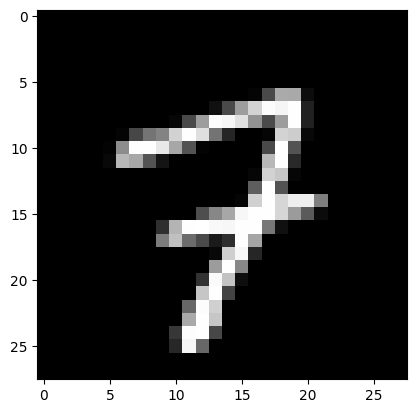

tensor(7)


In [145]:


test_data = get_mnist_data(train=False)
x_test, y_test = test_data
number = np.random.randint(0, 10000)
target = x_test[number].reshape((28, 28))
print(np.argmax(net(x_test[number]).detach().numpy()))
image = Image.fromarray(target.numpy())
imshow(image)
print(y_test[number])


## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2024